In [17]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [18]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [19]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


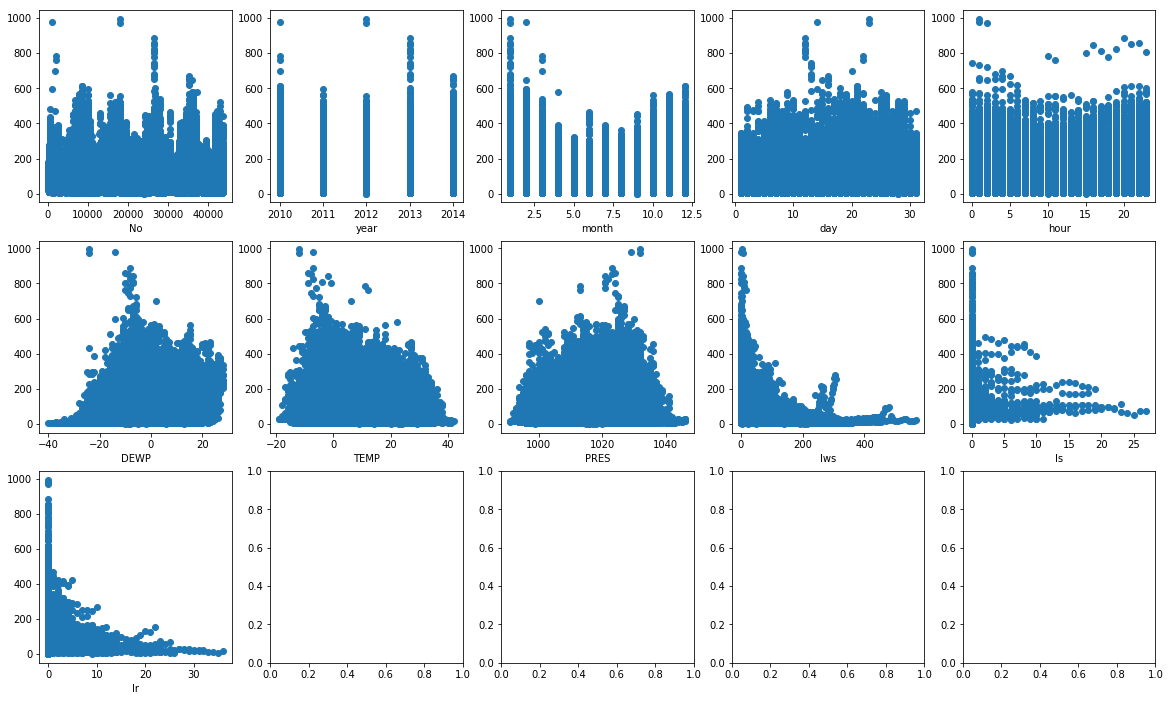

In [20]:
import matplotlib.pyplot as plt
x_vars = X.columns.values

_, subplot_arr = plt.subplots(3, 5, figsize=(20, 12))
for idx, x_var in enumerate(x_vars):
  x_idx = idx // 5
  y_idx = idx % 5
  subplot_arr[x_idx, y_idx].scatter(df[x_var], df['pm2.5'])
  subplot_arr[x_idx, y_idx].set_xlabel(x_var)

plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])


#Training data points: 1491
#Testing data points: 639


In [22]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        for i in range(int(self.n_iter)):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

MSE train: 201.718, test: 1485.687
R^2 train: 0.987, test: 0.905


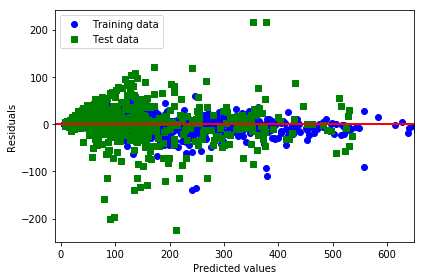

In [23]:
forest = RandomForestRegressor(
    n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=650, lw=2, color='red')
plt.xlim([-10, 650])
plt.tight_layout()
plt.show()

In [24]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            x_vars[indices[f]], 
                            importances[indices[f]]))

 1) DEWP                           0.460799
 2) No                             0.233257
 3) day                            0.130054
 4) PRES                           0.052546
 5) Iws                            0.050156
 6) TEMP                           0.032446
 7) hour                           0.029527
 8) month                          0.008861
 9) year                           0.001695
10) Is                             0.000422
11) Ir                             0.000238


In [25]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.02, prefit=True)
Z_forest = sfm.transform(X)

for f in range(Z_forest.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            x_vars[indices[f]], 
                            importances[indices[f]]))

 1) DEWP                           0.460799
 2) No                             0.233257
 3) day                            0.130054
 4) PRES                           0.052546
 5) Iws                            0.050156
 6) TEMP                           0.032446
 7) hour                           0.029527


In [26]:
X = X[['DEWP', 'No', 'day', 'PRES', 'Iws'] ]
X_train, X_test, y_train, y_test = train_test_split(Z_forest, y, test_size=0.3,random_state=0)

sc_x = StandardScaler()
sc_x.fit(X_train)

X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)


In [27]:
from sklearn.preprocessing import PolynomialFeatures

quartic = PolynomialFeatures(degree=4)
X_quar_train = quartic.fit_transform(X_train_std)
quar_regr = LinearRegressionGD(eta=10e-10,n_iter=10000000)
X_quar_test = quartic.fit_transform(X_test_std)

quar_regr = quar_regr.fit(X_quar_train, y_train)
y_train_pred = quar_regr.predict(X_quar_train)
y_test_pred = quar_regr.predict(X_quar_test)

In [28]:
#R2
quartic_r2_train = r2_score(y_train, y_train_pred)
quartic_r2_test = r2_score(y_test, y_test_pred)

R^2 train: 0.79, test: 0.75


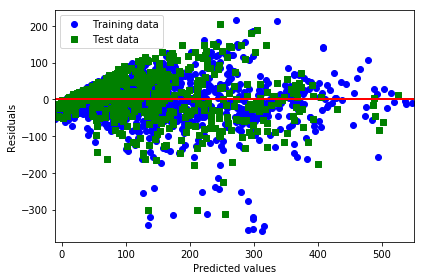

In [36]:
print('R^2 train: %.2f, test: %.2f' % (quartic_r2_train, quartic_r2_test))
# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=550, lw=2, color='red')
plt.xlim([-10, 550])
plt.tight_layout()
plt.show()
